# 07_SAG_gtdbtk

This document explores the SAG GTDB output. Imported data is the original data files from google drive. This document is written in the Python coding language.

## Load packages and data

In [177]:
import pandas as pd
import os
import sys
import csv
import numpy as np
import matplotlib
import glob
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

sags = pd.read_csv('~/Documents/Bigelow/Virus_Project/OMZ_MH_Analysis/Data/sag_data/MPsag_mx2_proximeta_matches_gtdbtk.csv')
sags.rename(columns={'classification_via_GTDBTk': 'classification'}, inplace=True) # rename classification column

# split the classification into tax level columns and rename
sags[['domain', 'phyla', 'class', 'order', 'family', 'genus', 'species']]=sags.classification.str.split(';', expand=True)
sags['domain'] = sags['domain'].str.replace('d__', '') # remove the d__ in front of all observations
sags['phyla'] = sags['phyla'].str.replace('p__', '')
sags['class'] = sags['class'].str.replace('c__', '')
sags['order'] = sags['order'].str.replace('o__', '')
sags['family'] = sags['family'].str.replace('f__', '')
sags['genus'] = sags['genus'].str.replace('g__', '')
sags['species'] = sags['species'].str.replace('s__', '')

## How many SAGs were classified in total?

In [2]:
total_sags = len(sags['domain'])
total_sags

350

## How many SAGs were classified to at least that classification level?

In [3]:
# function to count how many were classified based on an input dataframe and taxonomic level

def count_classified(sags, level):
    
    level_prefix = level[0] + '__' # create level prefixes
    
    subdf = sags[(sags[level] != 'Unclassified') & (~sags[level].isna()) & (sags[level] != '') & (sags[level] != level_prefix)] # all conditions that level is unannotated
   
    return len(subdf)  # returns number of rows with annotation for level

level_counts = [] # set up empty level counts string

levels = ['domain','phyla','class','order','family','genus','species'] # create a levels list

# for loop that counts how many were classified using the count_classified function created above
for level in levels:
    lcount = count_classified(sags, level)
    
    print('There are', lcount, 'SAGs annotated to', level,".") 
    
    level_counts.append(lcount)

There are 350 SAGs annotated to domain .
There are 327 SAGs annotated to phyla .
There are 326 SAGs annotated to class .
There are 324 SAGs annotated to order .
There are 314 SAGs annotated to family .
There are 279 SAGs annotated to genus .
There are 163 SAGs annotated to species .


In [4]:
# create a data frame of the number of MAGs associated with each level
dict_sags = {'tax_level': levels, 'num_sags_classified': level_counts} # create a dictionary with the number classified for each level

GTDB_sags = pd.DataFrame(data = dict_sags)

GTDB_sags['percent_classified'] = GTDB_sags['num_sags_classified']/total_sags*100 # add a column to the dataframe that is the percent of MAGs

GTDB_sags

,tax_level,num_sags_classified,percent_classified
0,domain,350,100.000000
1,phyla,327,93.428571
2,class,326,93.142857
3,order,324,92.571429
4,family,314,89.714286
5,genus,279,79.714286
6,species,163,46.571429


Text(0.5, 1.0, 'Percent of SAGs Classified with GTDB')

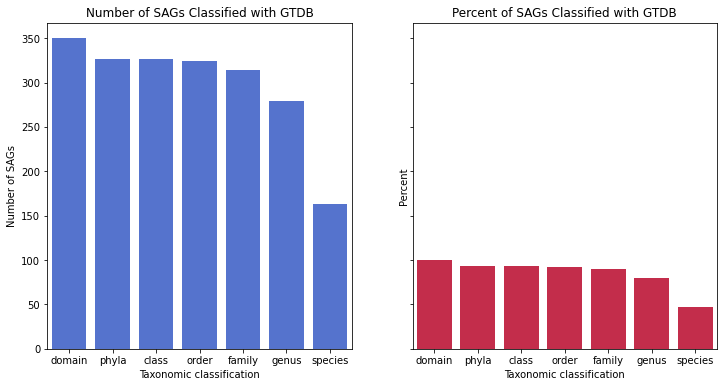

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6),sharex=True, sharey=True)

sns.barplot(x = 'tax_level', y= 'num_sags_classified', data = GTDB_sags, color= 'royalblue', ax = axes[0])
axes[0].set_xlabel('Taxonomic classification')
axes[0].set_ylabel('Number of SAGs')
axes[0].set_title('Number of SAGs Classified with GTDB')

sns.barplot(x = 'tax_level', y= 'percent_classified', data = GTDB_sags, color = 'crimson', ax = axes[1])
axes[1].set_xlabel('Taxonomic classification')
axes[1].set_ylabel('Percent')
axes[1].set_title('Percent of SAGs Classified with GTDB')

## What are the most common classifications?

In [6]:
# top 5 groups in each level
for taxa in ['domain', 'phyla','class','order','family','genus','species']:
    print(sags.groupby(taxa)['well'].count().sort_values(ascending=False)[:5])
    print("\n")

domain
Bacteria    308
0            23
Archaea      19
Name: well, dtype: int64


phyla
Marinisomatota      129
Proteobacteria      115
SAR324               14
Thermoplasmatota     12
Chloroflexota        11
Name: well, dtype: int64


class
Marinisomatia          129
Alphaproteobacteria     62
Gammaproteobacteria     53
SAR324                  14
Poseidoniia             12
Name: well, dtype: int64


order
Marinisomatales     106
Pelagibacterales     40
SCGC-AAA003-L08      23
HIMB59               20
UBA11654             19
Name: well, dtype: int64


family
TCS55                56
Pelagibacteraceae    39
GCA-002718135        20
UBA11654             19
D37C17               19
Name: well, dtype: int64


genus
                48
UBA2126         27
TCS55           25
UBA2125         18
Pelagibacter    16
Name: well, dtype: int64


species
                       164
TCS55 sp018674655       25
UBA2126 sp002436185     17
UBA2125 sp002329125     17
UBA2128 sp002471865     16
Name: well, dtype: 

Text(0.06, 0.5, 'Count')

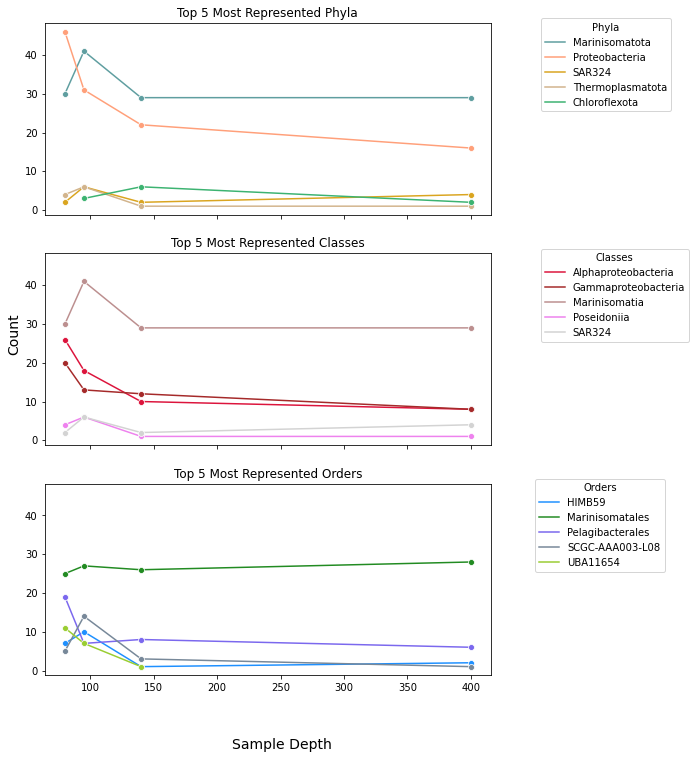

In [22]:
# create a data frame with only the top 5 phyla
phyla_sub = sags.loc[sags['phyla'].isin(['Marinisomatota', 'Proteobacteria', 'SAR324','Thermoplasmatota','Chloroflexota'])]
phyla_sub = phyla_sub.groupby(['depth', 'phyla'], as_index=False)['well'].count()

# create a data frame with only the top 5 classes
class_sub = sags.loc[sags['class'].isin(['Marinisomatia', 'Alphaproteobacteria', 'Gammaproteobacteria','SAR324','Poseidoniia'])]
class_sub = class_sub.groupby(['depth','class'], as_index=False)['well'].count()

# create a dataframe with only the top 5 orders
order_sub = sags.loc[sags['order'].isin(['Marinisomatales', 'Pelagibacterales', 'SCGC-AAA003-L08','HIMB59','UBA11654'])]
order_sub = order_sub.groupby(['depth','order'], as_index=False)['well'].count()

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(8,12))

sns.lineplot(x = 'depth', y= 'well', data = phyla_sub, hue = 'phyla', palette=phyla_color_map, marker='o', ax = axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Top 5 Most Represented Phyla')
axes[0].legend(bbox_to_anchor=(1.1, 1.05),title='Phyla')

sns.lineplot(x = 'depth', y= 'well', data = class_sub, hue = 'class', palette=class_color_map, marker='o', ax = axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Top 5 Most Represented Classes')
axes[1].legend(bbox_to_anchor=(1.1, 1.05),title='Classes')

sns.lineplot(x = 'depth', y= 'well', data = order_sub, hue = 'order', palette=order_color_map, marker='o', ax = axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_title('Top 5 Most Represented Orders')
axes[2].legend(bbox_to_anchor=(1.4, 1.05),title='Orders')

fig.text(0.45,0.04,'Sample Depth',fontsize=14)
fig.text(0.06, 0.5, 'Count',rotation='vertical',fontsize=14)

Text(0.5, 1.0, 'Top 10 Most Abundant Orders')

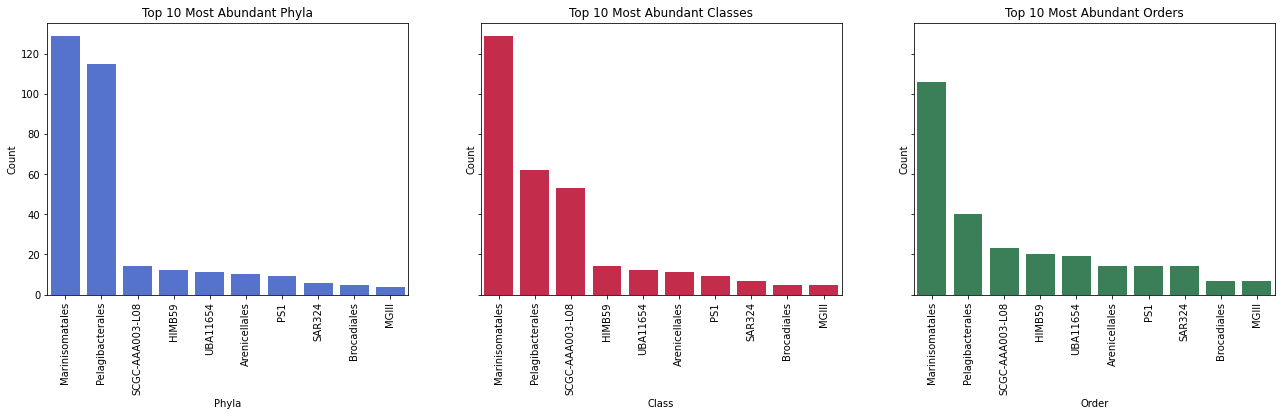

In [24]:
phyla_sags = sags.groupby('phyla', as_index=False)['well'].count().sort_values(by = 'well',ascending=False)
top_phyla_sags = phyla_sags [:10]

class_sags = sags.groupby('class', as_index=False)['well'].count().sort_values(by = 'well',ascending=False)
top_class_sags = class_sags [:10]

order_sags = sags.groupby('order', as_index=False)['well'].count().sort_values(by = 'well',ascending=False)
top_order_sags = order_sags [:10]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 5), sharex=True, sharey=True)

for ax in axes:
    ax.tick_params(axis='x', rotation=90)

sns.barplot(x = 'phyla', y= 'well', data = top_phyla_sags, color = 'royalblue', ax = axes[0])
axes[0].set_xlabel('Phyla')
axes[0].set_ylabel('Count')
axes[0].set_title('Top 10 Most Abundant Phyla')

sns.barplot(x = 'class', y= 'well', data = top_class_sags, color = 'crimson', ax = axes[1])
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Top 10 Most Abundant Classes')

sns.barplot(x = 'order', y= 'well', data = top_order_sags, color = 'seagreen', ax = axes[2])
axes[2].set_xlabel('Order')
axes[2].set_ylabel('Count')
axes[2].set_title('Top 10 Most Abundant Orders')

## Plot Tax Level

Text(0.5, 1.0, 'Count')

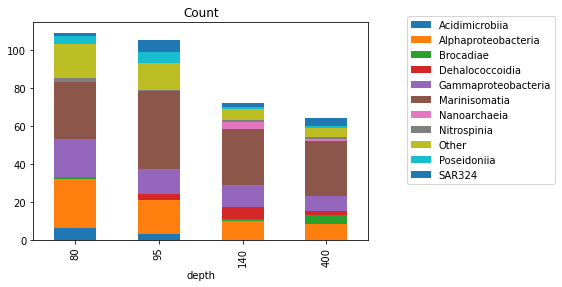

In [31]:
top_10_class_sags = list(sags.groupby('class', as_index = False)['well'].count().sort_values(by = 'well', ascending = False)[:10]['class'])

plot_class_sags = []

for item in sags['class']:
    if item in top_10_class_sags:
        plot_class_sags.append(item)
    else:
        plot_class_sags.append('Other')

sags['plot_class'] = plot_class_sags

class_counts_sags = sags.groupby(['depth', 'plot_class'], as_index = False)['well'].count().pivot(columns = 'plot_class', index = 'depth', values = 'well')

class_counts_sags.plot.bar(stacked = True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Count')

Text(0.5, 1.0, 'Percent')

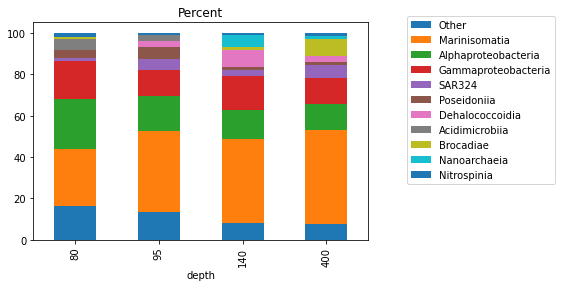

In [33]:
column_order = ['Other'] + top_10_class_sags

class_pcts_sags = class_counts_sags.div(class_counts_sags.sum(axis=1), axis=0)
class_pcts_sags = round(class_pcts_sags * 100, 1)



class_pcts_sags[column_order].plot.bar(stacked = True)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Percent')